# Libaries

In [1]:
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# First Phase

In [2]:
class FashionMNISTManager:
    """
    A class to handle data preparation, loading, and EDA for Fashion-MNIST project (Phase 1).
    """
    def __init__(self, data_root="./data", batch_size=128, seed=42, val_ratio=0.1):
        self.data_root = data_root
        self.batch_size = batch_size
        self.seed = seed
        self.val_ratio = val_ratio

        self.class_names = [
            "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
            "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
        ]

        # Determine device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Placeholders
        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None
        self.train_loader = None
        self.val_loader = None
        self.test_loader = None

        # Initialize
        self._set_seed()
        self._prepare_transforms()

    def _set_seed(self):
        """Sets seed for reproducibility."""
        torch.manual_seed(self.seed)
        torch.cuda.manual_seed_all(self.seed)
        np.random.seed(self.seed)
        random.seed(self.seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        print(f"[INFO] Seed set to {self.seed}")

    def _prepare_transforms(self):
        """Defines the preprocessing pipeline."""
        # Standard transform for VAE input (Normalized to [-1, 1])
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            # transforms.Normalize((0.5,), (0.5,))
        ])
        # Raw transform for EDA (Just [0, 1])
        self.eda_transform = transforms.ToTensor()

    def prepare_data(self):
        """Downloads data, splits into train/val, and creates loaders."""
        print("[INFO] Loading and Splitting Data...")

        # Load Full Train Data
        full_train_dataset = datasets.FashionMNIST(
            root=self.data_root, train=True, download=True, transform=self.transform
        )

        # Load Test Data
        self.test_dataset = datasets.FashionMNIST(
            root=self.data_root, train=False, download=True, transform=self.transform
        )

        # Split Train/Val
        n_total = len(full_train_dataset)
        n_val = int(n_total * self.val_ratio)
        n_train = n_total - n_val

        self.train_dataset, self.val_dataset = random_split(
            full_train_dataset,
            [n_train, n_val],
            generator=torch.Generator().manual_seed(self.seed)
        )

        # Create DataLoaders
        self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
        self.val_loader = DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)
        self.test_loader = DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)

        self.report_data_stats()

    def report_data_stats(self):
        """
        Reports the number of samples in train/val/test sets and the shape of each sample.
        """
        if self.train_dataset is None:
            raise ValueError("Data not prepared. Call prepare_data() first.")

        # Get one sample from each dataset to inspect shape
        train_sample, _ = self.train_dataset[0]
        val_sample, _ = self.val_dataset[0]
        test_sample, _ = self.test_dataset[0]

        print("=" * 50)
        print("DATA STATISTICS REPORT")
        print("=" * 50)
        print(f"Train samples      : {len(self.train_dataset):,}")
        print(f"Validation samples : {len(self.val_dataset):,}")
        print(f"Test samples       : {len(self.test_dataset):,}")
        print("-" * 50)
        print("Shape of each sample:")
        print(f"  Train sample shape     : {train_sample.shape}")
        print(f"  Validation sample shape: {val_sample.shape}")
        print(f"  Test sample shape      : {test_sample.shape}")
        print("=" * 50)


    def get_loaders(self):
        """Returns the data loaders."""
        if self.train_loader is None:
            raise ValueError("Data not prepared. Call prepare_data() first.")
        return self.train_loader, self.val_loader, self.test_loader

    def sanity_check(self, n=25):
        """Visualizes a batch of images to check data integrity."""
        print("[INFO] Performing Sanity Check...")
        images, labels = next(iter(self.train_loader))

        images = images[:n]
        labels = labels[:n]

        # Denormalize: [-1, 1] -> [0, 1] for plotting
        images = images * 0.5 + 0.5

        plt.figure(figsize=(10, 10))
        for i in range(n):
            plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].squeeze(), cmap="gray")
            plt.title(self.class_names[labels[i]])
            plt.axis("off")
        plt.suptitle(f"Sanity Check: Batch of {n} Images", fontsize=16)
        plt.tight_layout()
        plt.show()

    def perform_eda(self):
        """Performs Exploratory Data Analysis."""
        print("[INFO] Starting EDA...")
        self._plot_class_distribution()
        self._plot_pixel_stats()

    def _plot_class_distribution(self):
        """Helper to plot class distribution."""
        subset_indices = self.train_dataset.indices
        original_dataset = self.train_dataset.dataset
        train_labels = [original_dataset.targets[i].item() for i in subset_indices]

        plt.figure(figsize=(10, 5))
        sns.countplot(x=train_labels)
        plt.xticks(ticks=range(10), labels=self.class_names, rotation=45)
        plt.title("Class Distribution in Training Set")
        plt.xlabel("Class")
        plt.ylabel("Count")
        plt.show()

    def _plot_pixel_stats(self):
        """
        Helper to plot pixel histograms using ALL data (No Sampling).
        Uses a separate raw loader to get [0,1] values.
        """
        # Load temporary raw dataset (No normalization)
        eda_dataset = datasets.FashionMNIST(
            root=self.data_root, train=True, download=True, transform=self.eda_transform
        )

        print(" -> Collecting ALL pixel statistics (this might take a few seconds)...")

        # Use a large batch size for faster iteration
        eda_loader = DataLoader(eda_dataset, batch_size=2048, num_workers=2, shuffle=False)

        all_means = []
        all_pixels = []

        for imgs, _ in eda_loader:
            # Flatten images in the batch -> [batch_size, 784]
            batch_flat = imgs.view(imgs.size(0), -1).numpy()

            # Mean per image
            all_means.extend(batch_flat.mean(axis=1))

            # Append ALL pixels to the list
            all_pixels.append(batch_flat.flatten())

        # Concatenate everything into one massive array
        # Total pixels approx: 60,000 * 784 = ~47 million floats
        all_pixels = np.concatenate(all_pixels)
        all_means = np.array(all_means)

        print(f" -> Analyzed {len(all_pixels):,} pixels across {len(all_means):,} images.")

        # Plot 1: Pixel Intensity Histogram (Full Data)
        plt.figure(figsize=(14, 5))
        plt.subplot(1, 2, 1)
        plt.hist(all_pixels, bins=50, color='purple', alpha=0.7)
        plt.title("Pixel Intensity Histogram (All Data [0,1])")
        plt.xlabel("Pixel Value")
        plt.ylabel("Frequency")

        # Plot 2: Mean Pixel Intensity per Image
        plt.subplot(1, 2, 2)
        plt.hist(all_means, bins=50, color='teal', alpha=0.7)
        plt.title("Mean Pixel Intensity per Image")
        plt.xlabel("Mean Intensity")
        plt.ylabel("Count")

        plt.tight_layout()
        plt.show()

In [3]:
# 1. Instantiation
data_manager = FashionMNISTManager(batch_size=128, seed=42)

[INFO] Seed set to 42


In [4]:
# 2. Preparation (Download, Split, Loaders)
data_manager.prepare_data()

[INFO] Loading and Splitting Data...


100%|██████████| 26.4M/26.4M [00:02<00:00, 9.52MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 203kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.77MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.7MB/s]

DATA STATISTICS REPORT
Train samples      : 54,000
Validation samples : 6,000
Test samples       : 10,000
--------------------------------------------------
Shape of each sample:
  Train sample shape     : torch.Size([1, 28, 28])
  Validation sample shape: torch.Size([1, 28, 28])
  Test sample shape      : torch.Size([1, 28, 28])


[INFO] Performing Sanity Check...


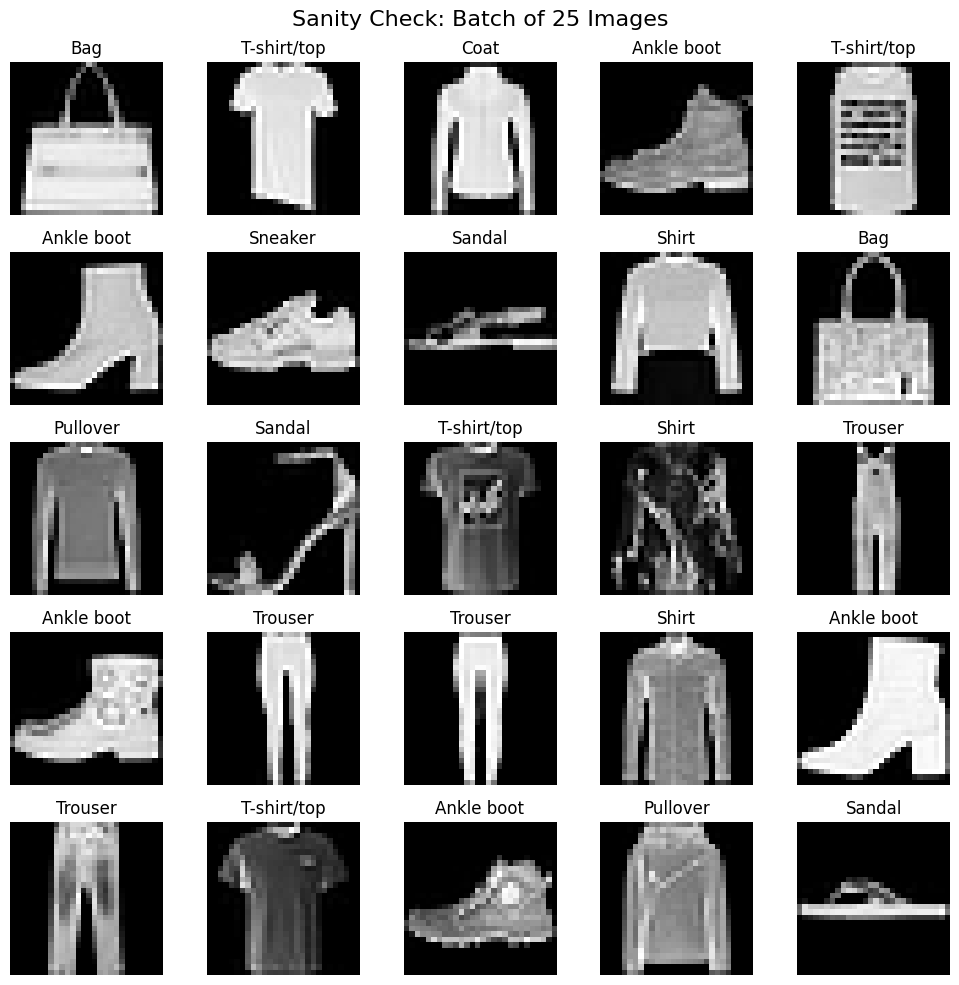

In [5]:
# 3. Sanity Check (Visualizing batch)
data_manager.sanity_check()

[INFO] Starting EDA...


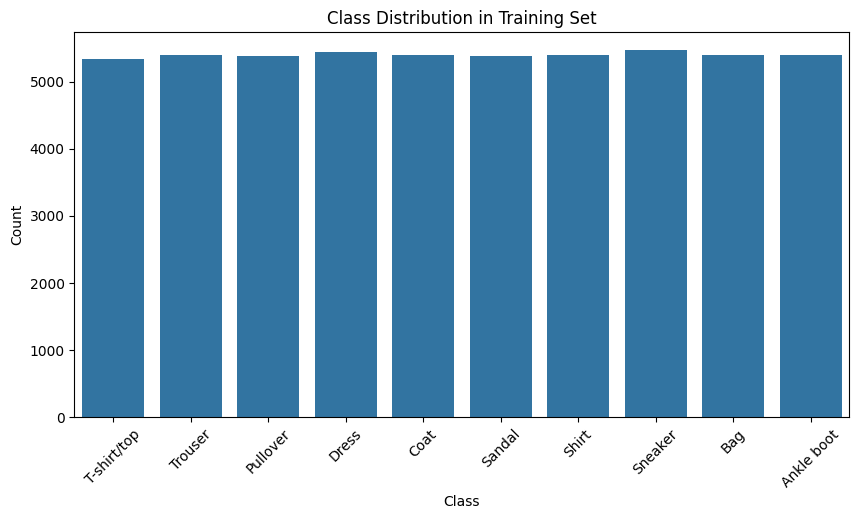

 -> Collecting ALL pixel statistics (this might take a few seconds)...
 -> Analyzed 47,040,000 pixels across 60,000 images.


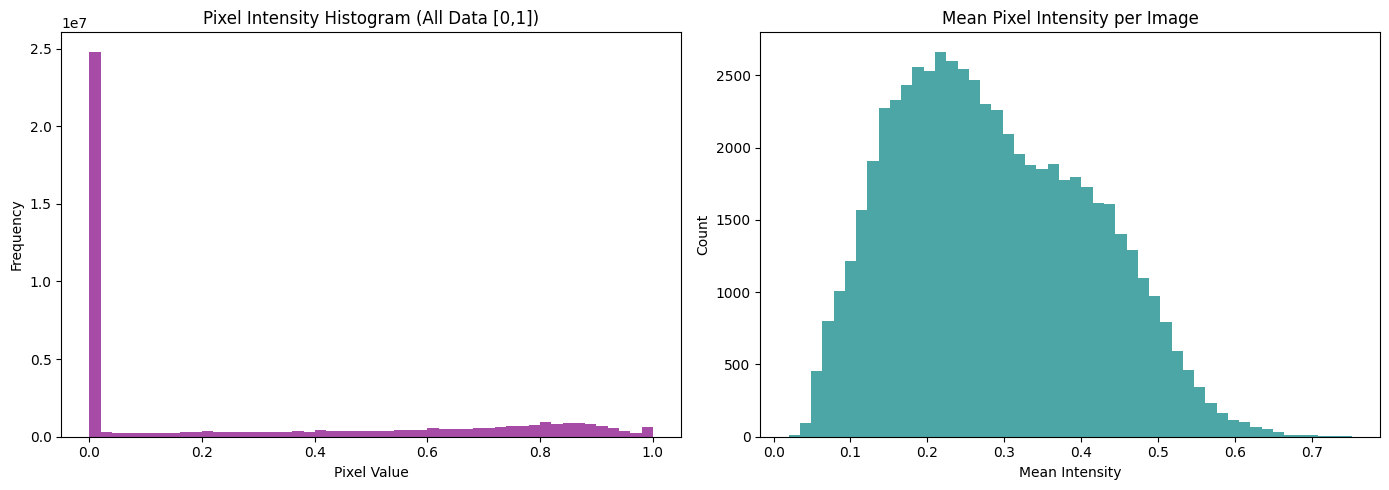

In [6]:
# 4. EDA (Class Dist, Pixel Histograms)
data_manager.perform_eda()

In [7]:
# 5. Access Loaders for Phase 2
train_loader, val_loader, test_loader = data_manager.get_loaders()
print("\n[INFO] Phase 1 Completed Successfully. Loaders are ready for Phase 2.")


[INFO] Phase 1 Completed Successfully. Loaders are ready for Phase 2.


# Second Phase

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

## VAE Architecture (Base Model)

In [9]:
class BaseVAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(BaseVAE, self).__init__()

        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(nn.Linear(784, 400), nn.ReLU())
        self.mu_layer = nn.Linear(400, self.latent_dim)
        self.log_var_layer = nn.Linear(400, self.latent_dim)
        self.decoder = nn.Sequential(nn.Linear(self.latent_dim, 400), nn.ReLU(), nn.Linear(400, 784), nn.Sigmoid())

    def encode(self, x):
        mu = self.mu_layer(self.encoder(x))
        logvar = self.log_var_layer(self.encoder(x))
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # create normal noise, use mu and logvar to create new variable
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x):
        # x: [batch size, 1, 28,28] -> x: [batch size, 784]
        x = x.view(-1, 784)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        new_x = self.decoder(z)
        return new_x, mu, logvar

## Loss Function & Training Loop

In [10]:
class VAETrainer:
    def __init__(self, model, manager, learning_rate=1e-3, beta=1):
        self.model = model.to(manager.device)
        self.manager = manager
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        self.beta = beta
        self.device = manager.device

    def loss_function(self, recon_x, x, mu, logvar, beta):
        BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = BCE + self.beta*KLD
        return loss, BCE, KLD

    def train(self, epochs=10):
        print(f"[INFO] Starting Training for {epochs} epochs...")
        train_loader, val_loader, _ = self.manager.get_loaders()
        history = {'train_loss': [], 'val_loss': []}

        for epoch in range(epochs):
            self.model.train()
            train_loss = 0
            recon_total = 0
            kld_total = 0

            for images, _ in train_loader:
                images = images.to(self.device)

                # Forward
                recon_images, mu, logvar = self.model(images)
                loss, recon, kld = self.loss_function(recon_images, images, mu, logvar, self.beta)

                # Backward
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                recon_total += recon.item()
                kld_total += kld.item()

            # Average over dataset
            avg_loss = train_loss / len(train_loader.dataset)
            avg_recon = recon_total / len(train_loader.dataset)
            avg_kld = kld_total / len(train_loader.dataset)

            # Validation
            val_metrics = self.evaluate(val_loader)
            history['train_loss'].append(avg_loss)
            history['val_loss'].append(val_metrics['total'])

            print(f"Epoch [{epoch+1}/{epochs}] "
                  f"Train Loss: {avg_loss:.4f} (Recon: {avg_recon:.1f}, KLD: {avg_kld:.1f}) | "
                  f"Val Loss: {val_metrics['total']:.4f}")

        return history

    def evaluate(self, loader):
        """
        Evaluates the model and returns dictionary of losses.
        """
        self.model.eval()
        total_loss = 0
        recon_total = 0
        kld_total = 0

        with torch.no_grad():
            for images, _ in loader:
                images = images.to(self.device)
                recon_images, mu, logvar = self.model(images)
                loss, recon, kld = self.loss_function(recon_images, images, mu, logvar, self.beta)

                total_loss += loss.item()
                recon_total += recon.item()
                kld_total += kld.item()

        n_samples = len(loader.dataset)
        return {
            'total': total_loss / n_samples,
            'recon': recon_total / n_samples,
            'kld': kld_total / n_samples
        }

## Visualization Tools

In [11]:
class VAEVisualizer:
    def __init__(self, model, manager):
        self.model = model
        self.manager = manager
        self.device = manager.device

    def show_reconstructions(self, n=20):
        """Display original vs reconstructed images with no vertical gap."""
        self.model.eval()
        _, _, test_loader = self.manager.get_loaders()

        images, _ = next(iter(test_loader))
        images = images[:n].to(self.device)

        with torch.no_grad():
            recon_images, _, _ = self.model(images)

        images_cpu = images.cpu()
        recon_images_cpu = recon_images.view(-1, 28, 28).cpu()

        # Reduced height to 3.5 to prevent stretching
        fig, axes = plt.subplots(2, n, figsize=(n * 0.8, 3.5))

        # hspace=0.0 eliminates the vertical gap between rows
        plt.subplots_adjust(hspace=0.0, wspace=0.05)

        for i in range(n):
            ax_orig = axes[0, i]
            ax_orig.imshow(images_cpu[i].squeeze(), cmap='gray')
            ax_orig.axis('off')

            ax_recon = axes[1, i]
            ax_recon.imshow(recon_images_cpu[i].squeeze(), cmap='gray')
            ax_recon.axis('off')

        # Use y-coordinate for titles to keep them clear of the tight images
        axes[0, 0].set_title("Original", loc='left', fontsize=12)
        axes[1, 0].set_title("Reconstructed", loc='left', fontsize=12)

        plt.show()

    def generate_samples(self, n=50):
        """Generate new images with tight vertical and horizontal spacing."""
        self.model.eval()
        z = torch.randn(n, self.model.latent_dim).to(self.device)

        with torch.no_grad():
            samples = self.model.decoder(z)
        samples = samples.view(-1, 28, 28).cpu()

        cols = int(n/3)
        # Standardize height to 3.0 for two rows
        fig, axes = plt.subplots(3, cols, figsize=(cols, 4.0))

        plt.subplots_adjust(hspace=0.0, wspace=0.05)

        axes_flat = axes.flatten()
        for i in range(len(axes_flat)):
            ax = axes_flat[i]
            if i < n:
                ax.imshow(samples[i], cmap='gray')
            ax.axis('off')

        plt.suptitle("Generated Samples from Latent Space", y=1.02)
        plt.show()

## Execution

In [12]:
# Prepare Data
manager = FashionMNISTManager()
manager.prepare_data()

[INFO] Seed set to 42
[INFO] Loading and Splitting Data...
DATA STATISTICS REPORT
Train samples      : 54,000
Validation samples : 6,000
Test samples       : 10,000
--------------------------------------------------
Shape of each sample:
  Train sample shape     : torch.Size([1, 28, 28])
  Validation sample shape: torch.Size([1, 28, 28])
  Test sample shape      : torch.Size([1, 28, 28])


In [13]:
# Init Model
base_vae = BaseVAE(latent_dim=2)

# Train
trainer = VAETrainer(base_vae, manager, beta=1)
history = trainer.train(epochs=30)

[INFO] Starting Training for 30 epochs...
Epoch [1/30] Train Loss: 294.1287 (Recon: 287.0, KLD: 7.1) | Val Loss: 274.7710
Epoch [2/30] Train Loss: 270.8081 (Recon: 264.0, KLD: 6.8) | Val Loss: 270.4768
Epoch [3/30] Train Loss: 267.7839 (Recon: 261.3, KLD: 6.5) | Val Loss: 268.0657
Epoch [4/30] Train Loss: 266.1976 (Recon: 259.8, KLD: 6.4) | Val Loss: 267.6021
Epoch [5/30] Train Loss: 265.0546 (Recon: 258.7, KLD: 6.4) | Val Loss: 266.1041
Epoch [6/30] Train Loss: 264.1633 (Recon: 257.8, KLD: 6.4) | Val Loss: 265.3819
Epoch [7/30] Train Loss: 263.5577 (Recon: 257.2, KLD: 6.4) | Val Loss: 264.7831
Epoch [8/30] Train Loss: 263.0271 (Recon: 256.7, KLD: 6.4) | Val Loss: 265.7561
Epoch [9/30] Train Loss: 262.5534 (Recon: 256.2, KLD: 6.4) | Val Loss: 263.6361
Epoch [10/30] Train Loss: 262.2773 (Recon: 255.9, KLD: 6.4) | Val Loss: 263.8242
Epoch [11/30] Train Loss: 261.8781 (Recon: 255.5, KLD: 6.4) | Val Loss: 263.1956
Epoch [12/30] Train Loss: 261.6487 (Recon: 255.3, KLD: 6.4) | Val Loss: 263.

## Visualization & Reporting


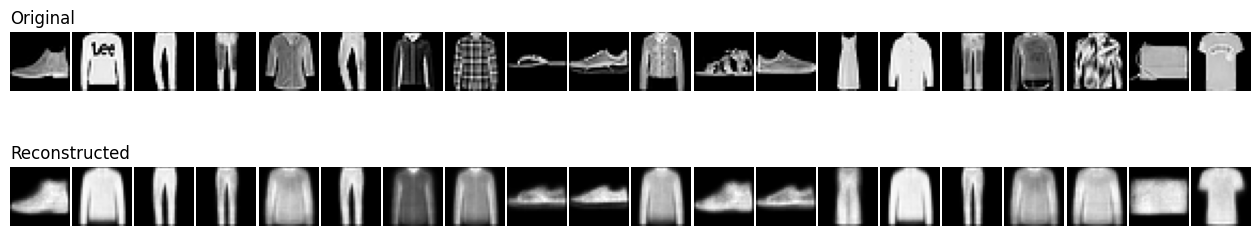

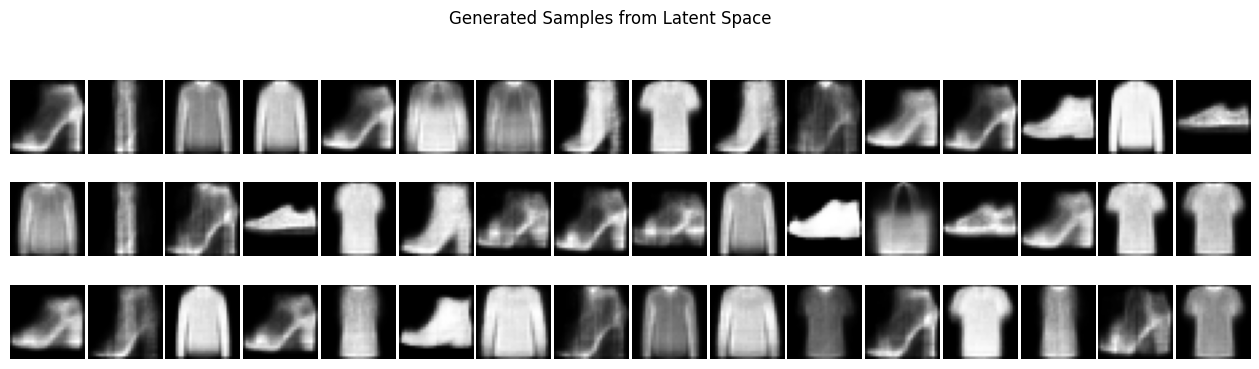

In [14]:
viz = VAEVisualizer(base_vae, manager)

viz.show_reconstructions(n=20)

print('\n')

viz.generate_samples(n=50)

## Report Test Metrics


In [15]:
_, _, test_loader = manager.get_loaders()
test_metrics = trainer.evaluate(test_loader)
print("=== Base Model Test Metrics ===")
print(f"Total Loss: {test_metrics['total']:.4f}")
print(f"Reconstruction Loss: {test_metrics['recon']:.4f}")
print(f"Regularization (KLD): {test_metrics['kld']:.4f}")

=== Base Model Test Metrics ===
Total Loss: 261.6644
Reconstruction Loss: 255.2216
Regularization (KLD): 6.4429


## Improvment of Outputs

### Improvement 1: Change Regularization Intensity
Here We use the same baseline architecture and trainer, just changing the beta parameter.


[INFO] Starting Training for 30 epochs...
Epoch [1/30] Train Loss: 291.9122 (Recon: 287.4, KLD: 9.0) | Val Loss: 275.1472
Epoch [2/30] Train Loss: 270.6515 (Recon: 266.7, KLD: 7.8) | Val Loss: 269.7398
Epoch [3/30] Train Loss: 266.8304 (Recon: 263.0, KLD: 7.6) | Val Loss: 268.9891
Epoch [4/30] Train Loss: 264.9628 (Recon: 261.2, KLD: 7.6) | Val Loss: 265.5948
Epoch [5/30] Train Loss: 263.8194 (Recon: 260.1, KLD: 7.5) | Val Loss: 265.0200
Epoch [6/30] Train Loss: 262.8468 (Recon: 259.1, KLD: 7.5) | Val Loss: 263.9176
Epoch [7/30] Train Loss: 262.1374 (Recon: 258.4, KLD: 7.5) | Val Loss: 264.1666
Epoch [8/30] Train Loss: 261.3898 (Recon: 257.6, KLD: 7.6) | Val Loss: 262.9693
Epoch [9/30] Train Loss: 260.8793 (Recon: 257.1, KLD: 7.6) | Val Loss: 262.8157
Epoch [10/30] Train Loss: 260.3081 (Recon: 256.5, KLD: 7.6) | Val Loss: 261.9263
Epoch [11/30] Train Loss: 259.8727 (Recon: 256.1, KLD: 7.6) | Val Loss: 261.4687
Epoch [12/30] Train Loss: 259.4479 (Recon: 255.6, KLD: 7.6) | Val Loss: 261.

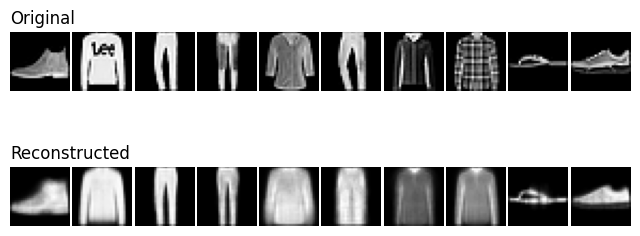


 === Improvement: Beta=0.5 Generation ===


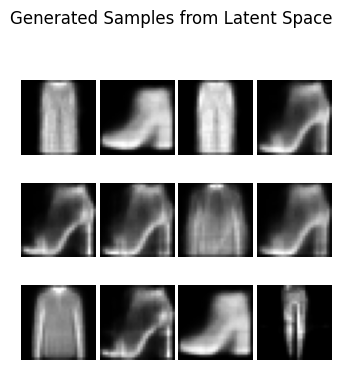


Beta=0.5 Metrics -> Total: 258.7, Recon: 254.9, KLD: 7.6


In [16]:
# Init Model
model_beta = BaseVAE(latent_dim=2)

# Train with a different Beta
trainer_beta = VAETrainer(model_beta, manager, beta=0.5)
history_beta = trainer_beta.train(epochs=30)

# Visualization
viz_beta = VAEVisualizer(model_beta, manager)
print("\n === Improvement: Beta=0.5 Reconstructions ===")
viz_beta.show_reconstructions(n=10)

print("\n === Improvement: Beta=0.5 Generation ===")
viz_beta.generate_samples(n=12)

# Metrics comparison
test_metrics_beta = trainer_beta.evaluate(manager.test_loader)
print(f"\nBeta=0.5 Metrics -> Total: {test_metrics_beta['total']:.1f}, Recon: {test_metrics_beta['recon']:.1f}, KLD: {test_metrics_beta['kld']:.1f}")

### Improvment 2: Change Latent Dimension

[INFO] Starting Training for 30 epochs...
Epoch [1/30] Train Loss: 283.7785 (Recon: 270.9, KLD: 12.8) | Val Loss: 259.2023
Epoch [2/30] Train Loss: 253.3278 (Recon: 239.1, KLD: 14.3) | Val Loss: 251.4580
Epoch [3/30] Train Loss: 248.8414 (Recon: 234.2, KLD: 14.6) | Val Loss: 249.0538
Epoch [4/30] Train Loss: 246.6995 (Recon: 231.8, KLD: 14.9) | Val Loss: 247.1062
Epoch [5/30] Train Loss: 245.3956 (Recon: 230.4, KLD: 15.0) | Val Loss: 246.2750
Epoch [6/30] Train Loss: 244.5147 (Recon: 229.3, KLD: 15.2) | Val Loss: 245.6560
Epoch [7/30] Train Loss: 243.8331 (Recon: 228.6, KLD: 15.3) | Val Loss: 244.8519
Epoch [8/30] Train Loss: 243.2581 (Recon: 228.0, KLD: 15.3) | Val Loss: 244.0811
Epoch [9/30] Train Loss: 242.7896 (Recon: 227.4, KLD: 15.3) | Val Loss: 244.1221
Epoch [10/30] Train Loss: 242.4521 (Recon: 227.1, KLD: 15.4) | Val Loss: 243.4358
Epoch [11/30] Train Loss: 242.1092 (Recon: 226.7, KLD: 15.4) | Val Loss: 243.0355
Epoch [12/30] Train Loss: 241.7985 (Recon: 226.4, KLD: 15.4) | Va

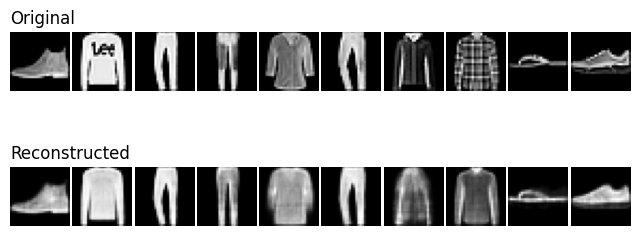


 === Improvement: Latent Dim 10 Generation ===


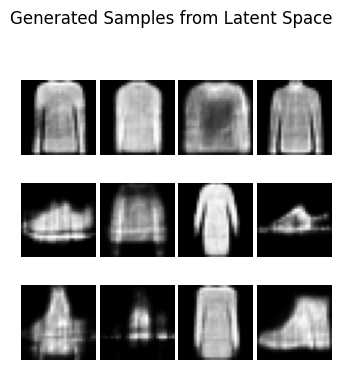


Latent Dim 20 Metrics -> Total: 241.5, Recon: 225.9, KLD: 15.6


In [17]:
# Init Model
model_ld10 = BaseVAE(latent_dim=10)

# Train using baseline beta
trainer_ld10 = VAETrainer(model_ld10, manager, beta=1)
history_ld10 = trainer_ld10.train(epochs=30)

# Visualization
viz_ld10 = VAEVisualizer(model_ld10, manager)

print("\n === Improvement: Latent Dim 10 Reconstructions ===")
viz_ld10.show_reconstructions(n=10)

print("\n === Improvement: Latent Dim 10 Generation ===")
viz_ld10.generate_samples(n=12)

# Metrics comparison
test_metrics_ld10 = trainer_ld10.evaluate(manager.test_loader)
print(f"\nLatent Dim 20 Metrics -> Total: {test_metrics_ld10['total']:.1f}, Recon: {test_metrics_ld10['recon']:.1f}, KLD: {test_metrics_ld10['kld']:.1f}")

### Improvment 3: Convolutional Architecture

In [18]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

class ConvVAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(),
            nn.Flatten()
        )

        self.mu_layer = nn.Linear(64 * 7 * 7, self.latent_dim)
        self.log_var_layer = nn.Linear(64 * 7 * 7, self.latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 64 * 7 * 7),
            Reshape(-1, 64, 7, 7),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1), nn.Sigmoid(),
            nn.Flatten()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu_layer(h)
        logvar = self.log_var_layer(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        new_x = self.decoder(z)
        return new_x, mu, logvar

[INFO] Starting Training for 30 epochs...
Epoch [1/30] Train Loss: 315.7633 (Recon: 310.0, KLD: 11.6) | Val Loss: 286.1460
Epoch [2/30] Train Loss: 279.1045 (Recon: 275.1, KLD: 8.1) | Val Loss: 276.9098
Epoch [3/30] Train Loss: 273.0092 (Recon: 269.2, KLD: 7.6) | Val Loss: 272.6512
Epoch [4/30] Train Loss: 269.8850 (Recon: 266.2, KLD: 7.3) | Val Loss: 270.3011
Epoch [5/30] Train Loss: 267.9640 (Recon: 264.4, KLD: 7.2) | Val Loss: 269.0805
Epoch [6/30] Train Loss: 266.6200 (Recon: 263.1, KLD: 7.1) | Val Loss: 267.9552
Epoch [7/30] Train Loss: 265.6698 (Recon: 262.2, KLD: 7.0) | Val Loss: 266.5888
Epoch [8/30] Train Loss: 264.8840 (Recon: 261.4, KLD: 7.0) | Val Loss: 266.6681
Epoch [9/30] Train Loss: 264.3042 (Recon: 260.8, KLD: 7.0) | Val Loss: 265.5095
Epoch [10/30] Train Loss: 263.7868 (Recon: 260.3, KLD: 7.0) | Val Loss: 265.3781
Epoch [11/30] Train Loss: 263.3584 (Recon: 259.9, KLD: 7.0) | Val Loss: 264.5019
Epoch [12/30] Train Loss: 262.9745 (Recon: 259.5, KLD: 7.0) | Val Loss: 264

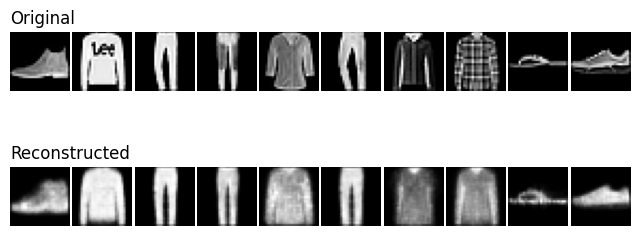


 === Improvement: ConvVAE Generation ===


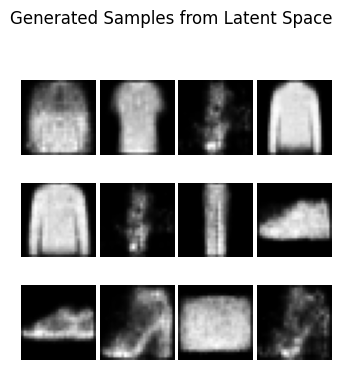


ConvVAE Metrics -> Total: 262.4, Recon: 258.9, KLD: 7.0


In [19]:
# Init Conv Model
model_conv = ConvVAE(latent_dim=2)

# Train using baseline trainer settings
trainer_conv = VAETrainer(model_conv, manager, beta=0.5)
history_conv = trainer_conv.train(epochs=30)

# Visualization
viz_conv = VAEVisualizer(model_conv, manager)

print("\n=== Improvement: ConvVAE Reconstructions ===")
viz_conv.show_reconstructions(n=10)

print("\n === Improvement: ConvVAE Generation ===")
viz_conv.generate_samples(n=12)

# Metrics comparison
test_metrics_conv = trainer_conv.evaluate(manager.test_loader)
print(f"\nConvVAE Metrics -> Total: {test_metrics_conv['total']:.1f}, Recon: {test_metrics_conv['recon']:.1f}, KLD: {test_metrics_conv['kld']:.1f}")

## Competition Criterion (FID)

In [20]:
import torch
import torch.nn as nn
from torchvision.models import resnet18
import numpy as np
from scipy import linalg

### Load the Provided Classifier

In [21]:
class FashionResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        m = resnet18(weights=None)
        m.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        m.maxpool = nn.Identity()
        m.fc = nn.Identity()
        self.backbone = m
        self.head = nn.Linear(512, num_classes)

    def forward(self, x: torch.Tensor):
        feats = self.backbone(x)
        logits = self.head(feats)
        return logits, feats

def load_classifier(model_path, device):
    model = FashionResNet18(num_classes=10)
    checkpoint = torch.load(model_path, map_location=device)
    state_dict = checkpoint["model_state_dict"]
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    return model

### FID Score Calculation

The **Fréchet Inception Distance (FID)** is the primary competition metric used to evaluate the quality and diversity of the 10,000 generated images.

#### 1. Representation Extraction
Instead of comparing raw pixels, we use the provided **FashionResNet18** classifier to extract high-level feature representations:
* **Real Features ($f_r$):** Extracted from 10,000 images in the test set.
* **Generated Features ($f_g$):** Extracted from 10,000 images generated by the VAE decoder.

#### 2. Mathematical Formulation
We assume the features follow a Multivariate Gaussian Distribution. The distance between the real distribution $(\mu_r, \Sigma_r)$ and generated distribution $(\mu_g, \Sigma_g)$ is calculated as:

$$FID = \|\mu_r - \mu_g\|^2 + \text{Tr}(\Sigma_r + \Sigma_g - 2\sqrt{\Sigma_r \Sigma_g})$$

* **$\|\mu_r - \mu_g\|^2$**: Measures the difference in the average visual features (Realism).
* **$\text{Tr}(\dots)$**: Measures the difference in the variety and spread of features (Diversity).

* A lower FID score indicates generated images that are statistically closer to the real Fashion-MNIST test set.

In [22]:
def calculate_fid(real_images, generated_images, classifier, device):
    """
    Computes the Fréchet Inception Distance (FID) between two sets of images.
    """
    classifier.eval()

    def get_features(images, batch_size=128):
        features_list = []
        with torch.no_grad():
            for i in range(0, len(images), batch_size):
                batch = images[i : i + batch_size].to(device)
                _, feats = classifier(batch)
                features_list.append(feats.cpu().numpy())
        return np.concatenate(features_list, axis=0)

    print("[INFO] Extracting features from Real Images...")
    act1 = get_features(real_images)

    print("[INFO] Extracting features from Generated Images...")
    act2 = get_features(generated_images)

    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    ssdiff = np.sum((mu1 - mu2) ** 2)

    covmean = linalg.sqrtm(sigma1.dot(sigma2))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

### Execution

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

classifier_path = "fashion_resnet18_classifier.pt"
classifier = load_classifier(classifier_path, device)

print("[INFO] Loading Real Images...")
_, _, test_loader = manager.get_loaders()
all_real_images = []
for imgs, _ in test_loader:
    all_real_images.append(imgs)
all_real_images = torch.cat(all_real_images, dim=0)

print("[INFO] Generating 10,000 Fake Images...")
base_vae.eval()
with torch.no_grad():
    z = torch.randn(20000, base_vae.latent_dim).to(device)
    generated_images = base_vae.decoder(z).view(-1, 1, 28, 28)

print("[INFO] Calculating FID Score...")
fid_score = calculate_fid(all_real_images, generated_images, classifier, device)

print(f"\n=========================================")
print(f" FINAL COMPETITION SCORE (FID): {fid_score:.4f}")
print(f"=========================================")

[INFO] Loading Real Images...
[INFO] Generating 10,000 Fake Images...
[INFO] Calculating FID Score...
[INFO] Extracting features from Real Images...
[INFO] Extracting features from Generated Images...

 FINAL COMPETITION SCORE (FID): 23.8946


# Third Phase


In [26]:
class VAEVisualizer:

     def generate_samples(self, n=50):
         """Generate new images with tight vertical and horizontal spacing."""
         self.model.eval()
         z = torch.randn(n, self.model.latent_dim).to(self.device)
         plt.suptitle("Generated Samples from Latent Space", y=1.02)
         plt.show()

def latent_traversal_grid(model, device, latent_dims, n_steps=7, value_range=(-3.0, 3.0), base_z=None):
    """Display latent traversal outputs in a regular grid (rows=latent_dims, cols=traversal values)."""
    model.eval()
    latent_dim = model.latent_dim

    if base_z is None:
        base_z = torch.zeros(latent_dim, device=device)
    else:
        base_z = base_z.to(device)

    values = torch.linspace(value_range[0], value_range[1], steps=n_steps, device=device)

    fig, axes = plt.subplots(len(latent_dims), n_steps, figsize=(n_steps * 1.2, len(latent_dims) * 1.2))
    if len(latent_dims) == 1:
        axes = np.expand_dims(axes, axis=0)

    with torch.no_grad():
        for r, d in enumerate(latent_dims):
            if d < 0 or d >= latent_dim:
                raise ValueError(f"latent dim index {d} is out of bounds for latent_dim={latent_dim}")
            for c, v in enumerate(values):
                z = base_z.clone()
                z[d] = v
                out = model.decoder(z.unsqueeze(0))
                img = out.view(-1, 28, 28)[0].detach().cpu().numpy()
                axes[r, c].imshow(img, cmap='gray')
                axes[r, c].axis('off')

    plt.tight_layout()
    plt.show()





 FINAL COMPETITION SCORE (FID): 23.8946


================ Phase 3: beta=0.5 =================
[INFO] Starting Training for 30 epochs...
Epoch [1/30] Train Loss: 274.7040 (Recon: 265.3, KLD: 18.9) | Val Loss: 249.6145
Epoch [2/30] Train Loss: 244.4663 (Recon: 234.5, KLD: 19.9) | Val Loss: 242.7979
Epoch [3/30] Train Loss: 240.1677 (Recon: 230.2, KLD: 19.9) | Val Loss: 240.3466
Epoch [4/30] Train Loss: 238.0642 (Recon: 228.1, KLD: 20.0) | Val Loss: 238.5685
Epoch [5/30] Train Loss: 236.8752 (Recon: 226.8, KLD: 20.1) | Val Loss: 237.7232
Epoch [6/30] Train Loss: 235.9380 (Recon: 225.9, KLD: 20.1) | Val Loss: 236.7286
Epoch [7/30] Train Loss: 235.2683 (Recon: 225.2, KLD: 20.1) | Val Loss: 236.3207
Epoch [8/30] Train Loss: 234.7320 (Recon: 224.7, KLD: 20.1) | Val Loss: 236.0002
Epoch [9/30] Train Loss: 234.3006 (Recon: 224.2, KLD: 20.2) | Val Loss: 235.3167
Epoch [10/30] Train Loss: 233.8971 (Recon: 223.8, KLD: 20.2) | Val Loss: 234.9285
Epoch [11/30] Train Loss: 233.5878 (Recon: 223.5, K

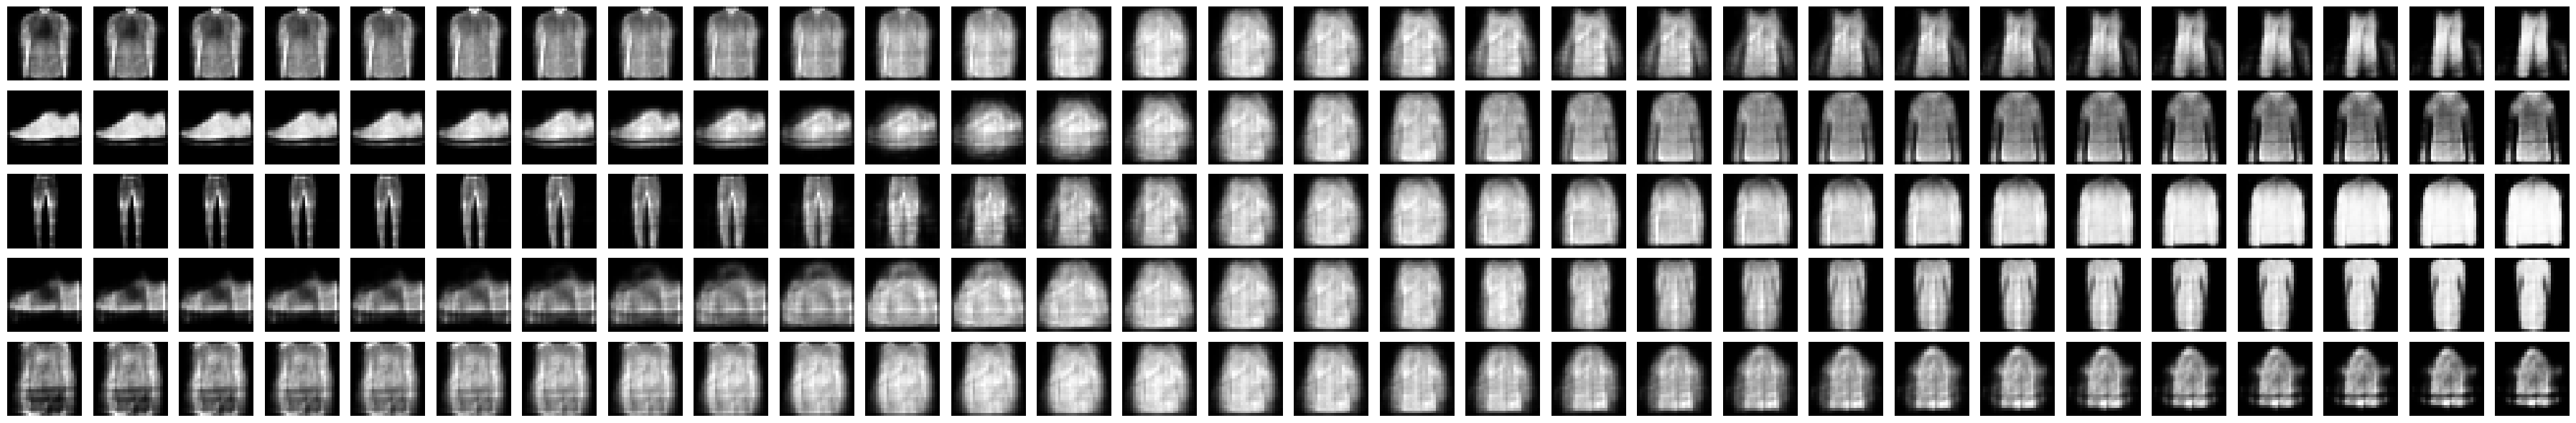



================ Phase 3: beta=1.0 =================
[INFO] Starting Training for 30 epochs...
Epoch [1/30] Train Loss: 284.5643 (Recon: 271.9, KLD: 12.7) | Val Loss: 258.5553
Epoch [2/30] Train Loss: 253.3458 (Recon: 239.1, KLD: 14.2) | Val Loss: 251.9039
Epoch [3/30] Train Loss: 248.9656 (Recon: 234.5, KLD: 14.4) | Val Loss: 249.0689
Epoch [4/30] Train Loss: 246.9214 (Recon: 232.4, KLD: 14.5) | Val Loss: 247.4015
Epoch [5/30] Train Loss: 245.6429 (Recon: 231.0, KLD: 14.6) | Val Loss: 246.4237
Epoch [6/30] Train Loss: 244.7516 (Recon: 230.0, KLD: 14.8) | Val Loss: 245.5508
Epoch [7/30] Train Loss: 244.0531 (Recon: 229.2, KLD: 14.8) | Val Loss: 244.8971
Epoch [8/30] Train Loss: 243.5247 (Recon: 228.6, KLD: 14.9) | Val Loss: 244.5116
Epoch [9/30] Train Loss: 242.9839 (Recon: 228.1, KLD: 14.9) | Val Loss: 243.9624
Epoch [10/30] Train Loss: 242.5943 (Recon: 227.6, KLD: 15.0) | Val Loss: 243.5351
Epoch [11/30] Train Loss: 242.2368 (Recon: 227.2, KLD: 15.0) | Val Loss: 243.3400
Epoch [12/

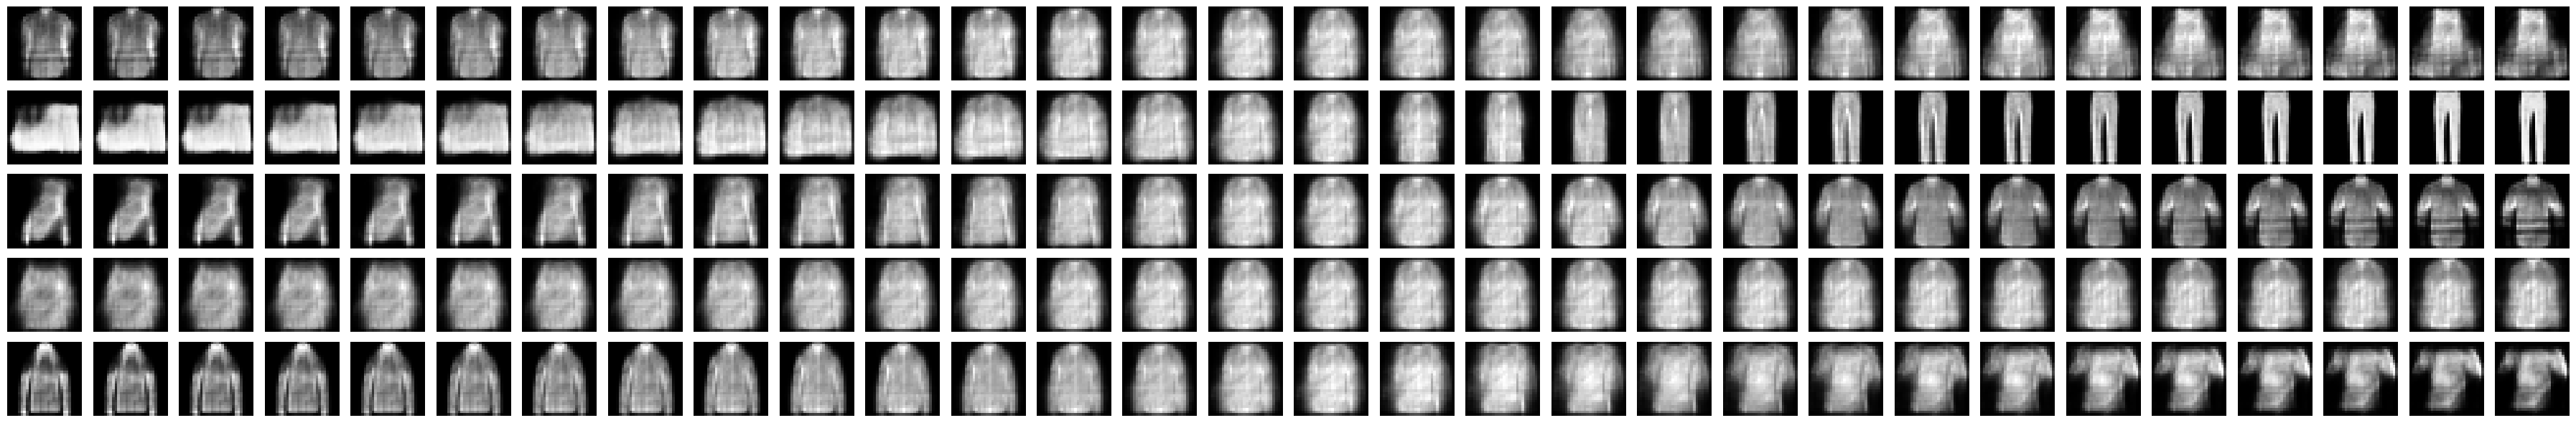



================ Phase 3: beta=4.0 =================
[INFO] Starting Training for 30 epochs...
Epoch [1/30] Train Loss: 309.1552 (Recon: 287.0, KLD: 5.5) | Val Loss: 285.9794
Epoch [2/30] Train Loss: 281.3462 (Recon: 256.2, KLD: 6.3) | Val Loss: 280.2441
Epoch [3/30] Train Loss: 277.3154 (Recon: 251.7, KLD: 6.4) | Val Loss: 277.2908
Epoch [4/30] Train Loss: 275.2919 (Recon: 249.3, KLD: 6.5) | Val Loss: 275.9244
Epoch [5/30] Train Loss: 274.1061 (Recon: 248.0, KLD: 6.5) | Val Loss: 274.8707
Epoch [6/30] Train Loss: 273.1547 (Recon: 246.9, KLD: 6.6) | Val Loss: 273.9081
Epoch [7/30] Train Loss: 272.4538 (Recon: 246.1, KLD: 6.6) | Val Loss: 273.2968
Epoch [8/30] Train Loss: 271.9794 (Recon: 245.5, KLD: 6.6) | Val Loss: 272.9551
Epoch [9/30] Train Loss: 271.4627 (Recon: 245.0, KLD: 6.6) | Val Loss: 272.5745
Epoch [10/30] Train Loss: 271.0397 (Recon: 244.5, KLD: 6.6) | Val Loss: 272.0520
Epoch [11/30] Train Loss: 270.7889 (Recon: 244.1, KLD: 6.7) | Val Loss: 271.9120
Epoch [12/30] Train L

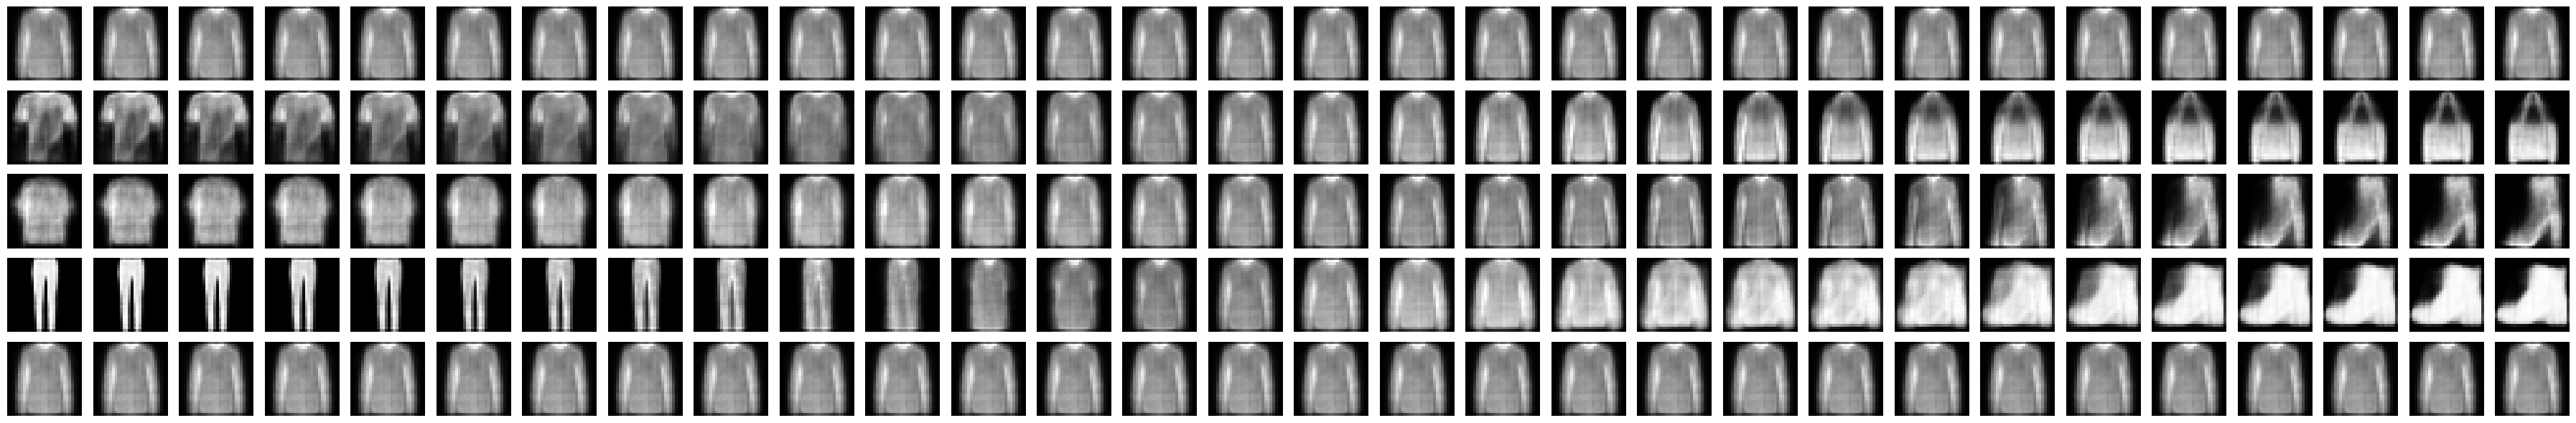

In [27]:
print(f"\n=========================================")
print(f" FINAL COMPETITION SCORE (FID): {fid_score:.4f}")
print(f"=========================================")


# ==========================
# Phase 3: regularization weight (beta) study + latent traversal
# ==========================
phase3_betas = [0.5, 1.0, 4.0]
phase3_latent_dim = 10
phase3_traversal_dims = [0, 1, 2, 3, 4]

_, _, phase3_test_loader = manager.get_loaders()

for beta in phase3_betas:
    print(f"\n\n================ Phase 3: beta={beta} =================")
    phase3_model = BaseVAE(latent_dim=phase3_latent_dim)
    phase3_trainer = VAETrainer(phase3_model, manager, beta=beta)
    phase3_trainer.train(epochs=30)

    phase3_metrics = phase3_trainer.evaluate(phase3_test_loader)
    print("=== Phase 3 Test Metrics ===")
    print(f"Total Loss: {phase3_metrics['total']:.4f}")
    print(f"Reconstruction Loss: {phase3_metrics['recon']:.4f}")
    print(f"Regularization (KLD): {phase3_metrics['kld']:.4f}")

    latent_traversal_grid(
        model=phase3_model,
        device=manager.device,
        latent_dims=phase3_traversal_dims,
        n_steps=30,
        value_range=(-3.0, 3.0),
    )
